<a href="https://colab.research.google.com/github/nmoisseeva/mv_ozone/blob/main/task2_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dec 19, 2023

#This script looks at trends in temperature and smoke ozone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import seaborn as sns
import os
import requests
import string
import pickle

mpl.rcParams['figure.dpi'] = 200



### INPUT ###

ap2014_path = '/content/drive/MyDrive/colab/consulting/mv/Temp_2002-2012.xlsx'
ap2024_path = '/content/drive/MyDrive/colab/consulting/mv/Temp_2013-2023.xlsx'
meta_path = '/content/drive/MyDrive/colab/consulting/mv/SelectMeta.xlsx'
fig_path = '/content/drive/MyDrive/colab/consulting/mv/figs/task2'
ozone_1h_path = '/content/drive/MyDrive/colab/consulting/mv/ozone_1h.pkl'
ozone_8h_path = '/content/drive/MyDrive/colab/consulting/mv/ozone_8h.pkl'


stations = ['T012','T026','T027','T029','T031','T033']  #testing
# stations = ['T001','T004','T006','T009','T012','T013','T014','T015','T017','T018','T020','T026','T027','T029','T030','T031','T032','T033','T034','T035','T043','T044','T045','T046','T050']



# stations =
quantiles = [0.5, 0.75, 0.95, 1]
lmt = [[0,20], [10,30], [10,30],[20,40]]  #plot limits for 1h plots
# lmt_8h = [[5,40], [15,45], [30,45]]  #plot limits for 1h plots


### end of input ###




In [2]:
#import data
ap2014 = pd.read_excel(ap2014_path,\
                      header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                       na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232','AutoCal','Purge','Spare','OutCal','Vandalism','Change'])


In [3]:
ap2024 = pd.read_excel(ap2024_path,\
          header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                         na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232','AutoCal','Purge','Spare','OutCal','Vandalism','Change'])

In [4]:
#import metadata
meta = pd.read_excel(meta_path)
meta['MV_ID'] = meta.MV_ID.apply(lambda x: 'T' + x[1:].zfill(3))
meta.set_index(meta.MV_ID, inplace=True)
meta.index.rename('stations', inplace=True)
meta.convert_dtypes()

NAPS_ID MV_ID                     StationName  \
stations                                                  
T001       100112  T001              DOWNTOWN VANCOUVER   
T002       100118  T002             VANCOUVER-KITSILANO   
T004       100110  T004         BURNABY-KENSINGTON PARK   
T006       100121  T006  NORTH VANCOUVER-SECOND NARROWS   
T009       100111  T009                      PORT MOODY   
T012       101101  T012                      CHILLIWACK   
T013       100125  T013                     NORTH DELTA   
T014       100126  T014                BURNABY MOUNTAIN   
T015       100127  T015                     SURREY EAST   
T017       100128  T017                  RICHMOND SOUTH   
T018       100119  T018                   BURNABY SOUTH   
T020       101202  T020                    PITT MEADOWS   
T022       100133  T022                BURNABY-BURMOUNT   
T023       100136  T023            BURNABY-CAPITOL HILL   
T024       100137  T024                   BURNABY NORTH   
T025       100131  T025                   SEYMOUR FALLS   
T026       100132  T026      NORTH VANCOUVER-MAHON PARK   
T027       101301  T027                         LANGLEY   
T029       101401  T029                            HOPE   
T030       101501  T030                     MAPLE RIDGE   
T031       100134  T031                RICHMOND AIRPORT   
T032       100135  T032                       COQUITLAM   
T033       101003  T033            ABBOTSFORD-MILL LAKE   
T034       101004  T034              ABBOTSFORD AIRPORT   
T035       100138  T035                   HORSESHOE BAY   
T039       100140  T039                      TSAWWASSEN   
T043       103602  T043                         MISSION   
T044       100143  T044                         AGASSIZ   
T045       101005  T045              ABBOTSFORD AIRPORT   
T046       100103  T046                 NEW WESTMINSTER   
T050       100141  T050           VANCOUVER CLARK DRIVE   

                                                    Address     Municipality  \
stations                                                                       
T001      ROBSON SQUARE - ROBSON AND HORNBY STREET Room ...        VANCOUVER   
T002                                  2550 WEST 10TH AVENUE        VANCOUVER   
T004                               6400 E. HASTINGS STREET           BURNABY   
T006                                     75 RIVERSIDE DRIVE  NORTH VANCOUVER   
T009                             MOODY STREET AND ESPLANADE       PORT MOODY   
T012                CHILLIWACK AIRPORT  46360 Airport Road.       CHILLIWACK   
T013                                    8544 - 116TH STREET            DELTA   
T014           SIMON FRASER UNIVERSITY - West Mall Building          BURNABY   
T015           Clayton Reservoir - 19000 BLOCK, 72ND AVENUE           SURREY   
T017                          WILLIAMS at 10371 ARAGON ROAD         RICHMOND   
T018                                     5455 RUMBLE STREET          BURNABY   
T020      MEADOWLANDS ELEM. SCHOOL - 18477 DEWDNEY TRUNK...     PITT MEADOWS   
T022                                 7815 SHELLMONT STREET           BURNABY   
T023                                      GROSVENOR CRESENT          BURNABY   
T024                               ETON AND MADISON AVENUE           BURNABY   
T025                                           SEYMOUR DAM   NORTH VANCOUVER   
T026                           16TH STREET AND JONES AVENUE  NORTH VANCOUVER   
T027                                    23752 - 52ND AVENUE          LANGLEY   
T029              HOPE AIRPORT - 62720 AIRPORT ROAD, RR#2               HOPE   
T030      GOLDEN EARS ELEM SCHOOL - 23124 118th AVE. AT ...      MAPLE RIDGE   
T031                                 3153 TEMPLETON STREET          RICHMOND   
T032                    1250 PINETREE WAY - Douglas College        COQUITLAM   
T033                        32995 BEVAN AVENUE AND PRIMROSE       ABBOTSFORD   
T034                                      31790 WALMSLEY RD   

In [5]:
#default date parsing flips month and day - do manually
ap2014.index = pd.to_datetime(ap2014.index,format='%d/%m/%Y %H:%M')
ap2024.index = pd.to_datetime(ap2024.index,format='%d/%m/%Y %H:%M')

#convert data to float
ap2014.convert_dtypes()
ap2024.convert_dtypes()

T012  T026  T027  T029  T031  T033
Date & Time                                            
2013-01-01 00:00:00  -1.2   0.0  -1.8  -0.6   0.0  -1.5
2013-01-01 01:00:00  -1.5  -0.7  -2.4  -1.0   0.4  -2.2
2013-01-01 02:00:00  -1.7   0.2  -2.8  -1.3   0.5  -2.8
2013-01-01 03:00:00  -1.2   0.1  -3.1  -1.3   0.5  -2.7
2013-01-01 04:00:00  -1.2  -0.3  -3.3  -1.6   0.3  -2.5
...                   ...   ...   ...   ...   ...   ...
2023-12-31 19:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
2023-12-31 20:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
2023-12-31 21:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
2023-12-31 22:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
2023-12-31 23:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>

[96408 rows x 6 columns]

In [ ]:
# #convert index to datetime and data to float
# ap2014.index = pd.to_datetime(ap2014.index)
# # ap2014.convert_dtypes()
# # ap2014['jday'] = ap2014.index.day_of_year

# ap2024.index = pd.to_datetime(ap2024.index)
# # ap2024.convert_dtypes()
# # ap2024['jday'] = ap2024.index.day_of_year


In [6]:
#assemble data, do grouping and averaging
temp_1h = pd.concat([ap2014, ap2024])
grp_1h = temp_1h.groupby(temp_1h.index.year)

In [7]:
#-----optional: save pickled data----------
import pickle
temp_1h.to_pickle('/content/drive/MyDrive/colab/consulting/mv/temperature_1h.pkl')


In [ ]:
#-----optional: check for random missing data strings-------
# pd.to_numeric(temp_1h.T033)

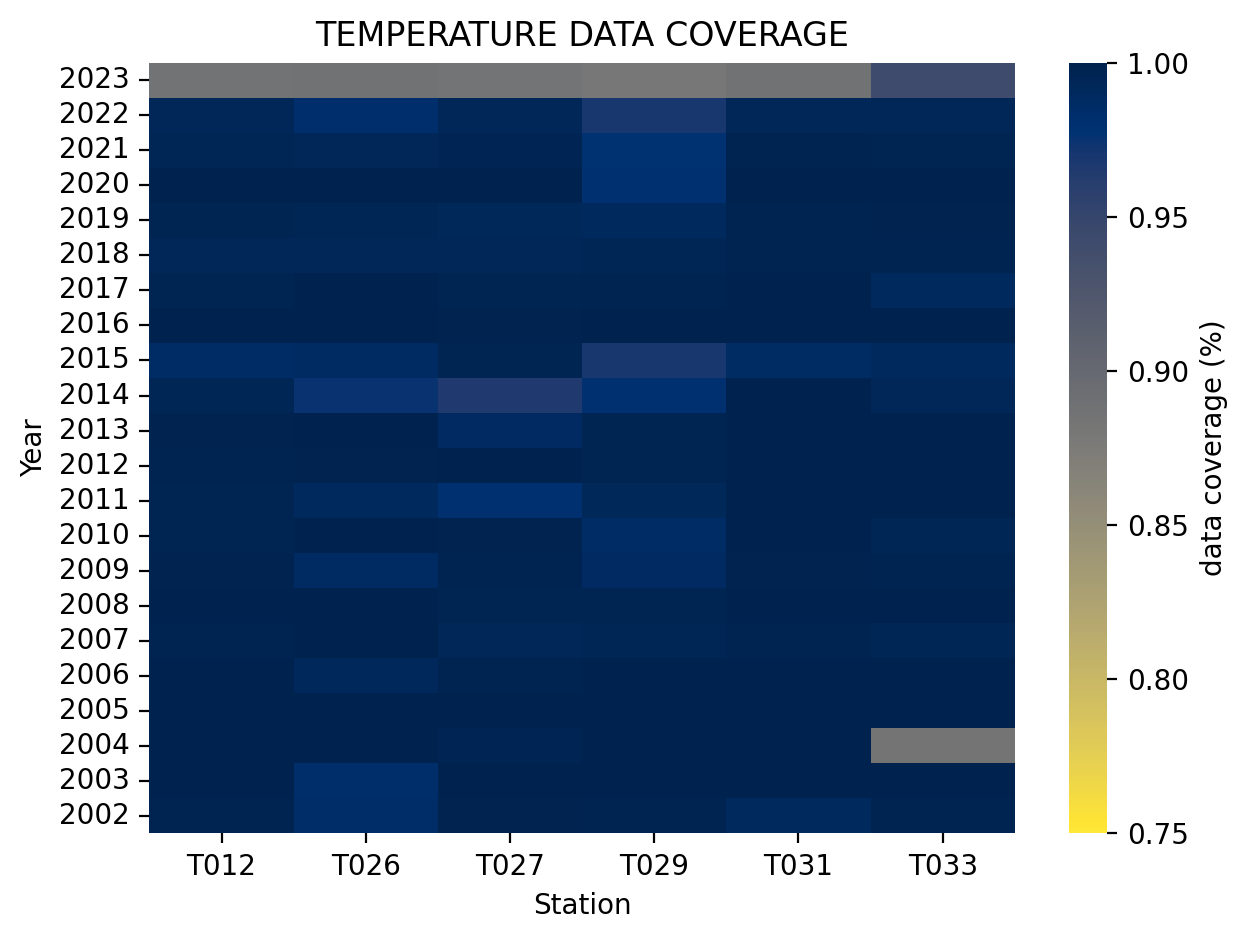

In [15]:
#look at how complete the data is
data_frac = grp_1h.count()/8760
plt.figure()
ax = plt.gca()
sns.heatmap(data_frac, vmin=0.75, vmax=1,cmap='cividis_r',cbar_kws={'label': 'data coverage (%)'})
ax.set(ylabel='Year', xlabel='Station', title='TEMPERATURE DATA COVERAGE')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(fig_path,'data_coverage_temperature.pdf'))

In [ ]:
# #sanity check: outlier check
# ozone_1h.boxplot()

In [9]:
# set up storage dataframe for trends
qKeys = ['stations'] + [f'Q{i}' for i in quantiles] + ['lat'] + ['lon']
trends = pd.DataFrame(columns = qKeys)
trends['stations'] = stations
trends.set_index(trends.stations, inplace=True)


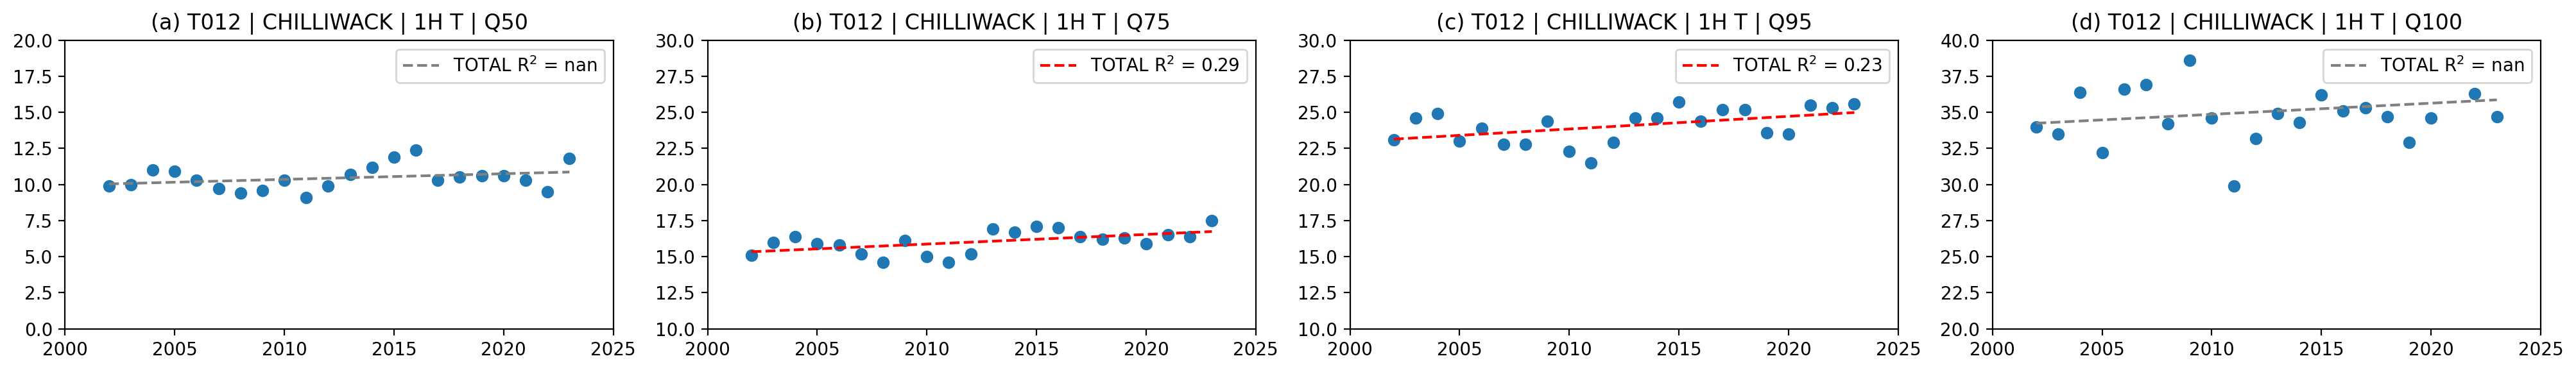

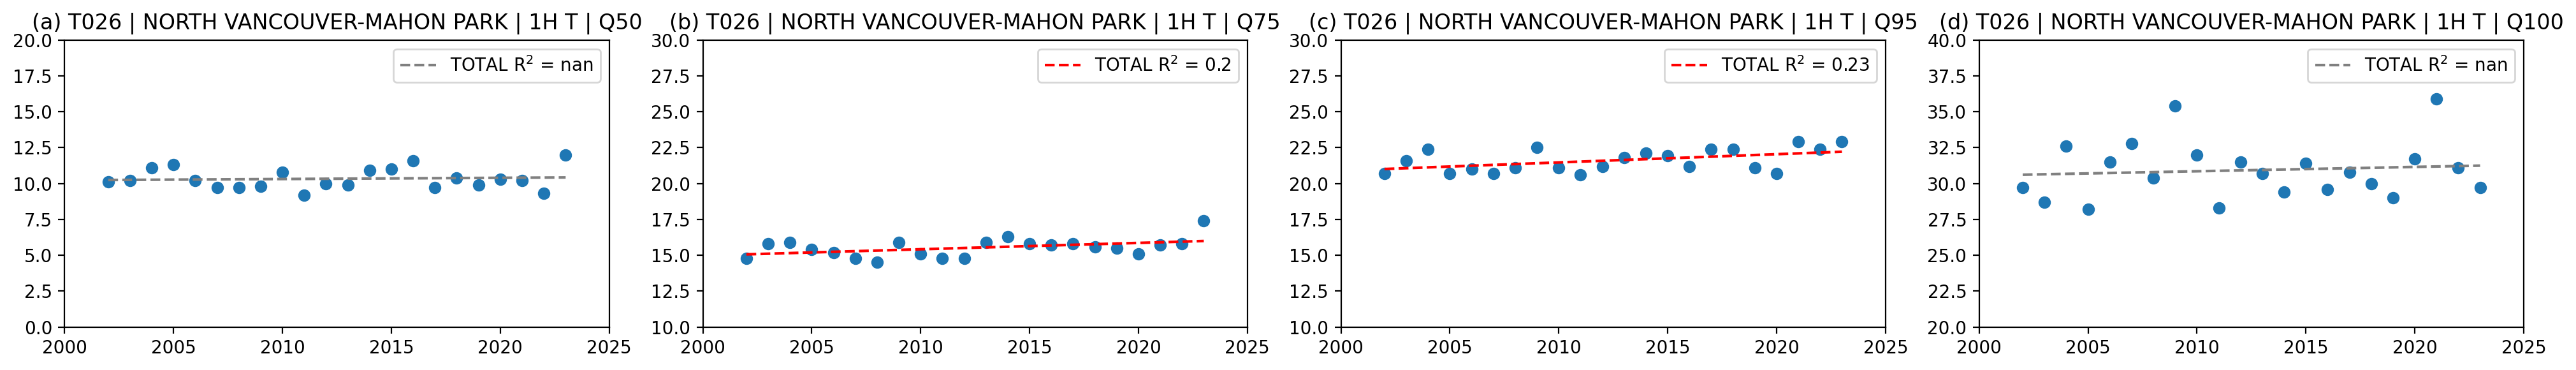

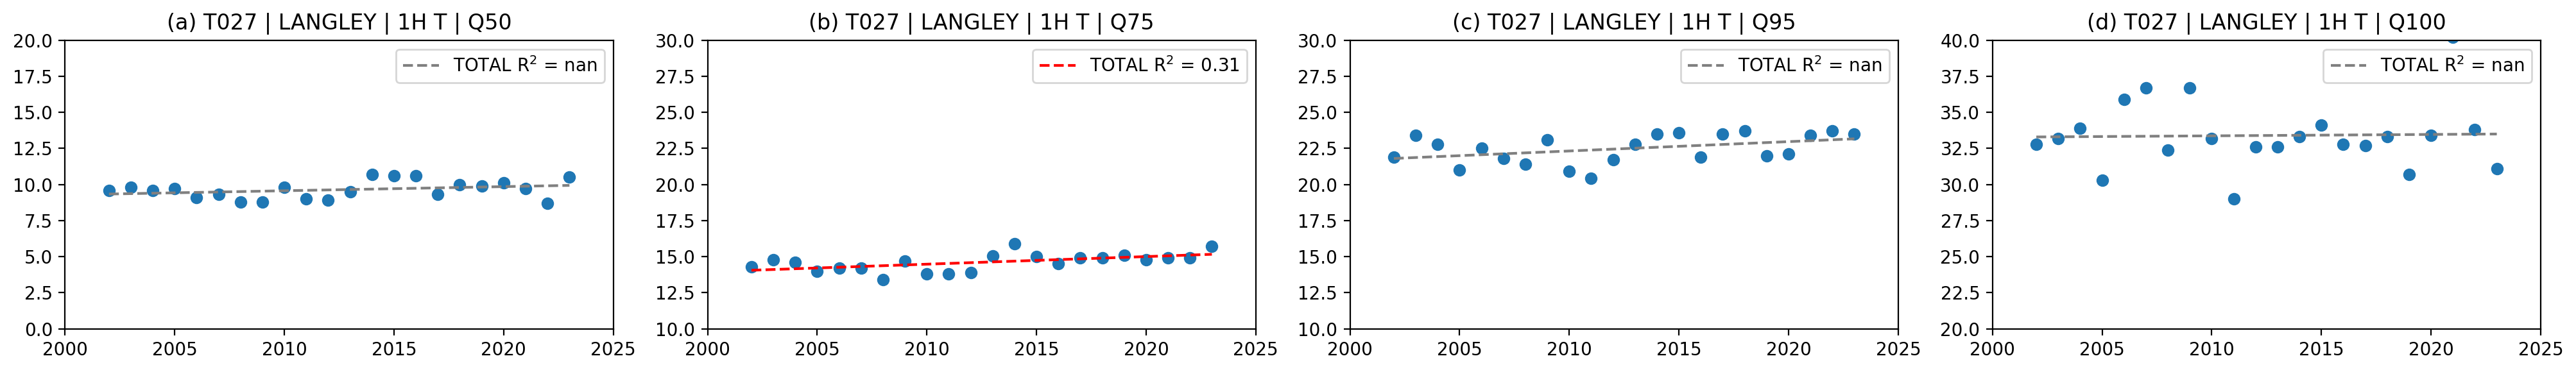

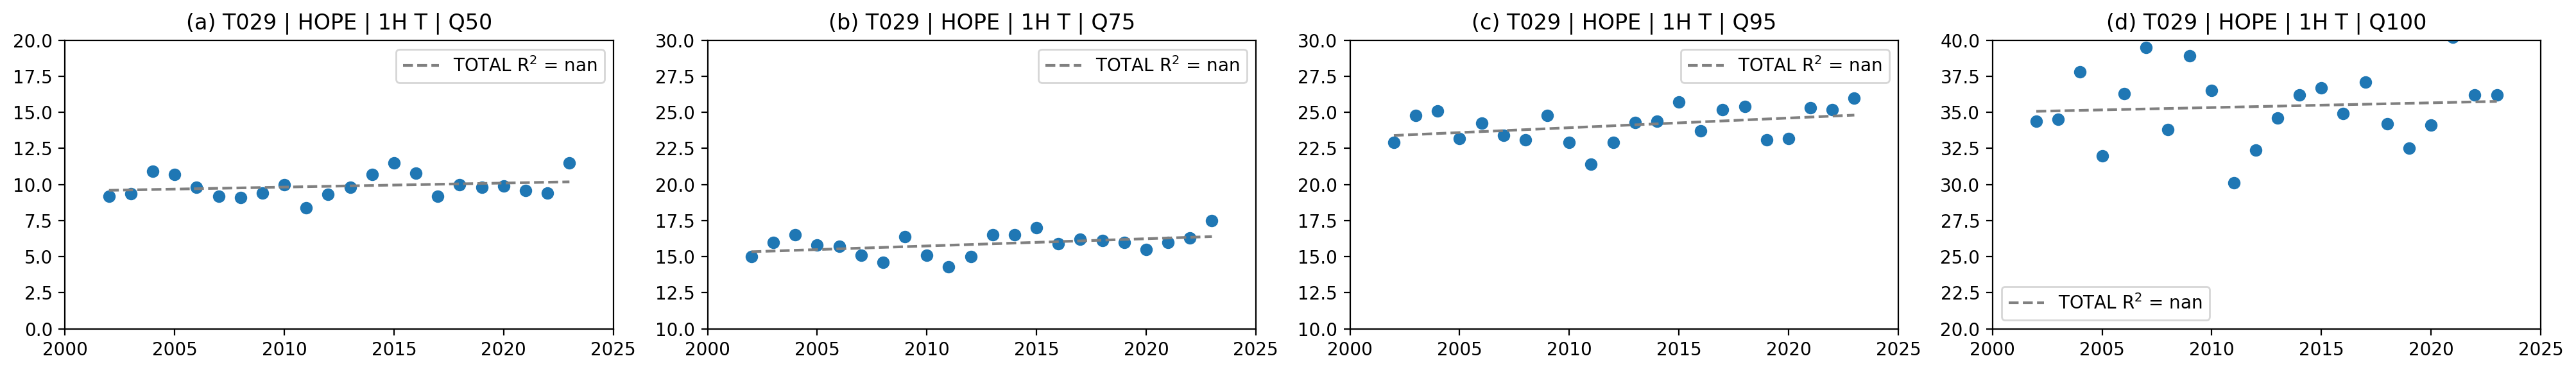

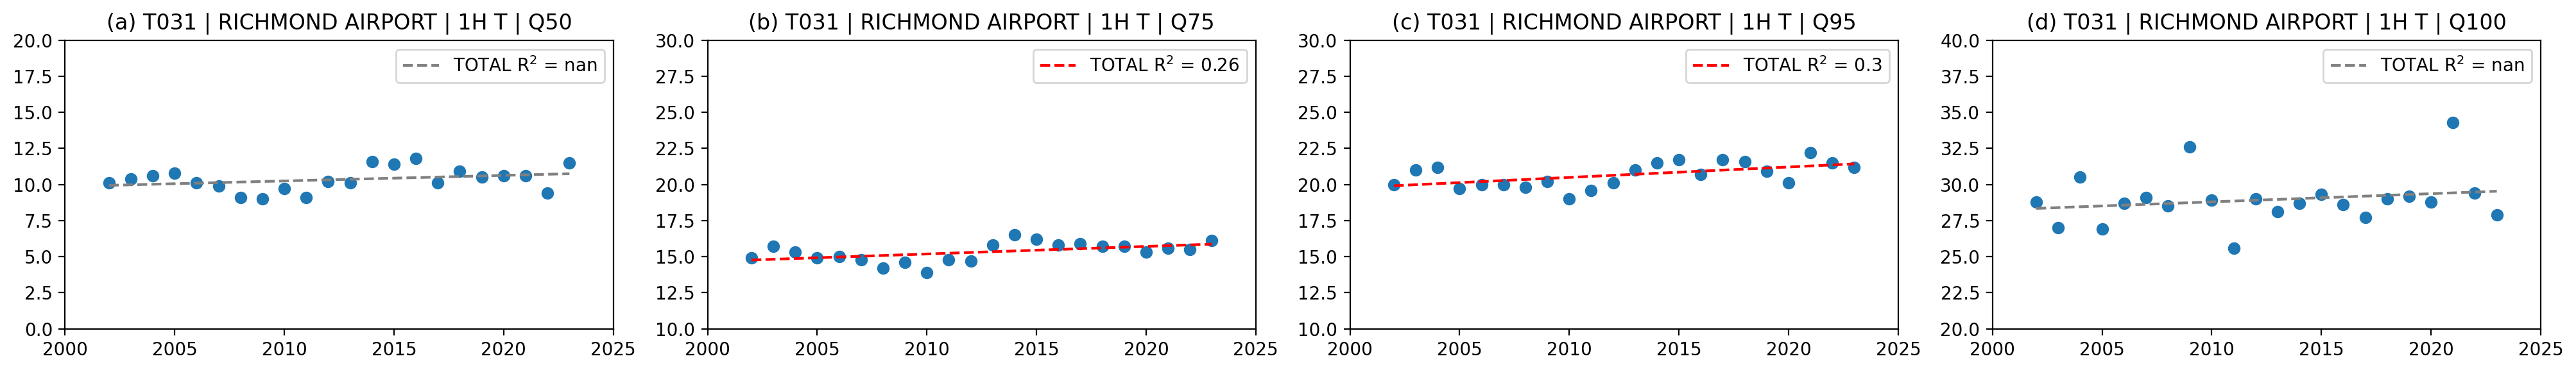

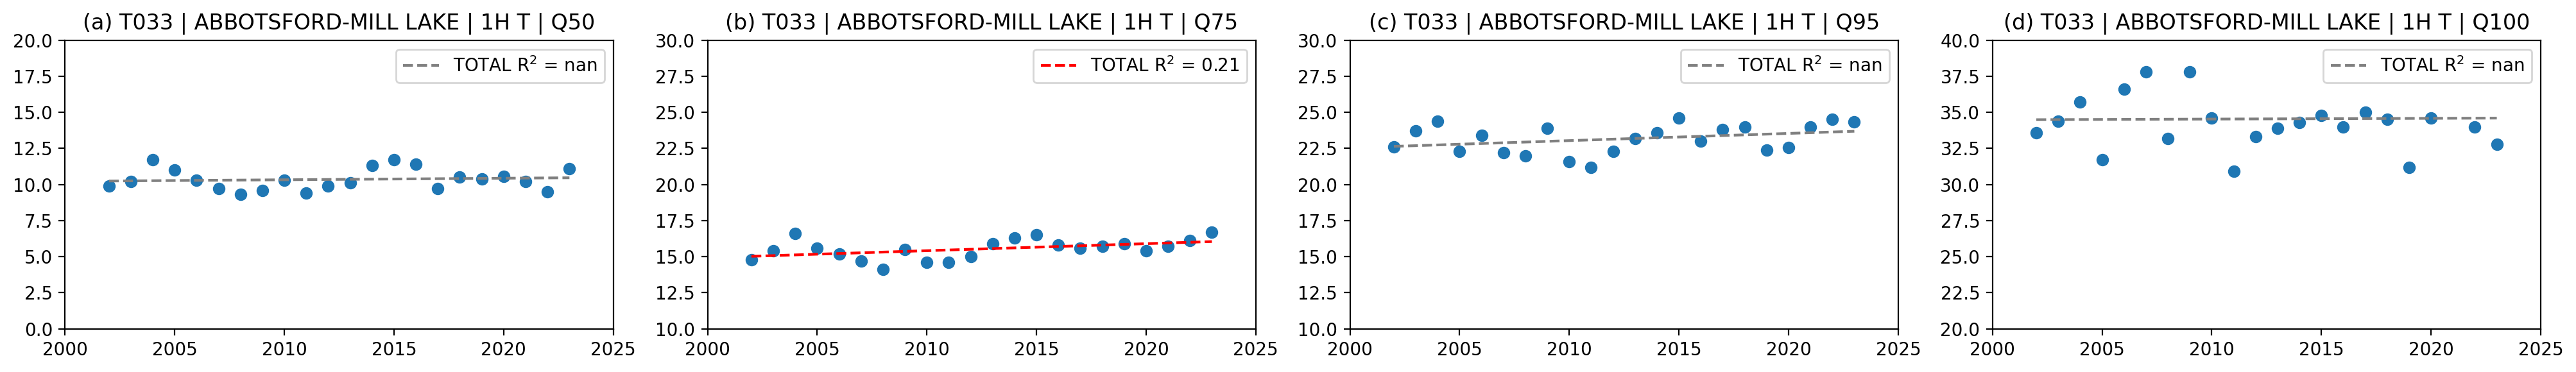

In [10]:
 #-------------1H TEMP------------------
plt_tag = [f'({i})' for i in list(string.ascii_lowercase)]

#loop through stations
for nStn, stn in enumerate(stations):

  #loop through quantiles
  numQnt = len(quantiles) + 1
  plt.figure(figsize=(5*numQnt,3))
  for nQ, qnt in enumerate(quantiles):

    #gather data
    q = grp_1h[stn].quantile(q=qnt)

    #------trendline------
    #add constant to predictor variables
    x = sm.add_constant(q.index.values)
    #fit linear regression model
    model = sm.OLS(q, x, missing='drop').fit()

    #get trend for last N years
    trend = model.predict(exog=x)
    #if significant, save the trend
    if model.pvalues.x1<0.05:
      trends.loc[stn,f'Q{qnt}'] = model.params.x1
    trends.loc[stn,['lat','lon']] = meta.loc[stn,['Lat','Lon']].values


    #----plotting-----
    plt.subplot(1,numQnt,nQ + 1)
    ax = plt.gca()
    plt.scatter(y = q, x=q.index)
    plt.plot(x[:,1],trend,c=['red' if model.pvalues.x1<0.05 else 'gray'][0],linestyle='--',\
            label = f'TOTAL R$^2$ = {[round(model.rsquared,2) if model.pvalues.x1<0.05 else "nan"][0]}')
    ax.set(title = f'{plt_tag[nQ]} {stn} | {meta.loc[stn,"StationName"]} | 1H T | Q{int(qnt*100)}', xlim=[2000, 2025],\
           ylim=lmt[nQ])
    plt.legend()
  plt.tight_layout()
  plt.savefig(os.path.join(fig_path,f'{stn}_T_1H.pdf'),bbox_inches = 'tight')


In [11]:
#---------- HEAT WAVE ANALYSIS ---------------
# ECCC heat warning criteria
#https://colab.research.google.com/drive/1WDPDInVwAqa7F3tqmwKTizbonSaF1wYr#scrollTo=ZGFLnn6-9zqH

#need two consecutive days
eccc_dfn = pd.DataFrame({'station' : stations,'tmin': np.empty(len(stations)),'tmax':np.empty(len(stations))})
eccc_dfn.set_index('station',inplace=True)

In [12]:
#manually assign values for stations depending on locatoin
eccc_dfn['tmin'].T026 = 16
eccc_dfn['tmin'].T031 = 16

eccc_dfn['tmin'].T012 = 17
eccc_dfn['tmin'].T027 = 17
eccc_dfn['tmin'].T029 = 17
eccc_dfn['tmin'].T033 = 17



eccc_dfn['tmax'].T026 = 29
eccc_dfn['tmax'].T031 = 29

eccc_dfn['tmax'].T012 = 33
eccc_dfn['tmax'].T027 = 33
eccc_dfn['tmax'].T029 = 33
eccc_dfn['tmax'].T033 = 33




In [13]:
#get daily max for each day of the year within each year
daily_1h_max = temp_1h[stations].groupby([temp_1h.index.year,temp_1h.index.day_of_year]).max()
daily_1h_max.index.set_names(['year','day'], inplace=True)

#get daily min
daily_1h_min = temp_1h[stations].groupby([temp_1h.index.year,temp_1h.index.day_of_year]).min()
daily_1h_min.index.set_names(['year','day'], inplace=True)

<ipython-input-132-98f072dd8ea9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_cnt_1h['period'].loc[2002:2012] = 'AP2014'


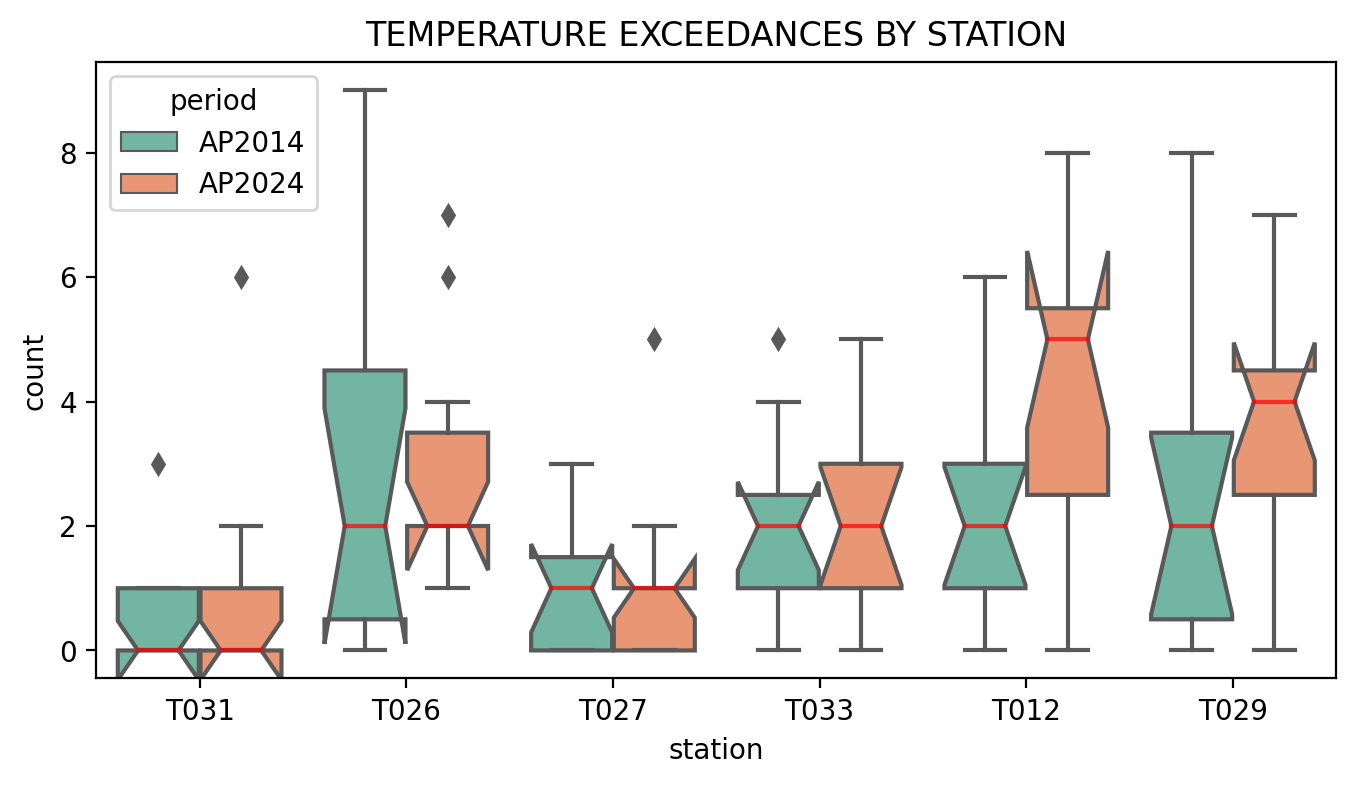

In [132]:
#loop through stations
ex_cnt_1h = pd.DataFrame()
for nStn, stn in enumerate(stations):
  stn_tmax = eccc_dfn.loc[stn,'tmax']
  ex_cnt_1h[stn] = daily_1h_max[stn].ge(stn_tmax).reset_index(0).groupby('year').agg('sum')
ex_cnt_1h['period'] = np.nan
ex_cnt_1h['period'].loc[2002:2012] = 'AP2014'
ex_cnt_1h['period'].loc[2013:2024] = 'AP2024'

sorted_stns = list(meta.loc[stations].sort_values('Lon', ascending=False).index.values)

plt.figure(figsize=(8,4))
ax = plt.gca()
sns.boxplot(x='variable',y='value',hue='period',data=ex_cnt_1h.melt(id_vars='period',value_vars=stations), \
            notch=True, palette='Set2', order=sorted_stns,medianprops=dict(color="red", alpha=0.7))
ax.set(xlabel='station',ylabel='count',title='TEMPERATURE EXCEEDANCES BY STATION')
plt.savefig(os.path.join(fig_path,'boxplot_1H_temperature_exceedances'),bbox_inches = 'tight')

In [16]:
#no look at achtual events
heat_events = pd.DataFrame(columns = ('year','station','start','length'))
cnt = 0
for nStn, stn in enumerate(stations):
  stn_tmax = eccc_dfn.loc[stn,'tmax']
  stn_tmin = eccc_dfn.loc[stn,'tmin']
  # ex_cnt_1h[stn] = daily_1h_max[stn].ge(stn_tmax).reset_index(0).groupby('year').agg('sum')

  #apply ECCC criteria
  single_day_criteria = daily_1h_max[stn].loc[(daily_1h_max[stn].ge(stn_tmax)) & (daily_1h_min[stn].ge(stn_tmin))]

  #check for consecutive days meeting the criteria
  for item in single_day_criteria.reset_index(0).groupby('year'):
    select_days = item[1].index.to_list()
    if len(select_days) > 1:
      if 1 in np.diff(select_days):
        # print(item[0],item[1].index[np.where(np.diff(select_days)==1)])
        heat_start = item[1].index[np.where(np.diff(select_days)==1)]
        print(f'{stn} | {item[0]} | Start day: {heat_start[0]} ndays = {len(heat_start)+1}')
        heat_events.loc[cnt, ['year','station','start','length']] = [item[0],stn,heat_start[0],len(heat_start)+1]
        cnt = cnt + 1

T012 | 2004 | Start day: 205 ndays = 2
T012 | 2006 | Start day: 202 ndays = 2
T012 | 2007 | Start day: 191 ndays = 2
T012 | 2009 | Start day: 154 ndays = 5
T012 | 2010 | Start day: 188 ndays = 3
T012 | 2021 | Start day: 176 ndays = 5
T012 | 2022 | Start day: 177 ndays = 4
T012 | 2023 | Start day: 225 ndays = 4
T026 | 2004 | Start day: 205 ndays = 3
T026 | 2006 | Start day: 202 ndays = 2
T026 | 2009 | Start day: 154 ndays = 6
T026 | 2010 | Start day: 226 ndays = 3
T026 | 2012 | Start day: 229 ndays = 2
T026 | 2013 | Start day: 181 ndays = 2
T026 | 2018 | Start day: 220 ndays = 3
T026 | 2021 | Start day: 177 ndays = 5
T026 | 2022 | Start day: 207 ndays = 5
T027 | 2009 | Start day: 209 ndays = 3
T027 | 2021 | Start day: 177 ndays = 3
T029 | 2004 | Start day: 204 ndays = 3
T029 | 2006 | Start day: 202 ndays = 3
T029 | 2007 | Start day: 191 ndays = 2
T029 | 2009 | Start day: 208 ndays = 4
T029 | 2010 | Start day: 226 ndays = 2
T029 | 2015 | Start day: 199 ndays = 2
T029 | 2016 | Start day: 

In [64]:
heat_events

year station start length
0   2004    T012   205      2
1   2006    T012   202      2
2   2007    T012   191      2
3   2009    T012   154      5
4   2010    T012   188      3
5   2021    T012   176      5
6   2022    T012   177      4
7   2023    T012   225      4
8   2004    T026   205      3
9   2006    T026   202      2
10  2009    T026   154      6
11  2010    T026   226      3
12  2012    T026   229      2
13  2013    T026   181      2
14  2018    T026   220      3
15  2021    T026   177      5
16  2022    T026   207      5
17  2009    T027   209      3
18  2021    T027   177      3
19  2004    T029   204      3
20  2006    T029   202      3
21  2007    T029   191      2
22  2009    T029   208      4
23  2010    T029   226      2
24  2015    T029   199      2
25  2016    T029   231      2
26  2017    T029   213      3
27  2018    T029   220      2
28  2021    T029   176      5
29  2023    T029   225      4
30  2009    T031   209      3
31  2021    T031   177      5
32  2004    T033   205      2
33  2006    T033   202      2
34  2009    T033   209      3
35  2010    T033   226      2
36  2018    T033   220      2
37  2021    T033   177      3

In [104]:
heat_events

T012  T026  T027  T029  T031  T033  period
year                                            
2002     2     2     0     1     0     2  AP2014
2003     1     0     1     3     0     1  AP2014
2004     4     4     1     4     1     4  AP2014
2005     0     0     0     0     0     0  AP2014
2006     2     2     2     3     0     2  AP2014
2007     2     1     2     2     1     2  AP2014
2008     2     5     0     1     0     1  AP2014
2009     6     9     3     8     3     3  AP2014
2010     5     5     1     5     0     5  AP2014
2011     0     0     0     0     0     0  AP2014
2012     1     3     0     0     1     2  AP2014
2013     3     2     0     3     0     3  AP2024
2014     2     2     2     1     0     2  AP2024
2015     6     3     1     7     2     1  AP2024
2016     4     2     0     3     0     2  AP2024
2017     5     2     0     4     0     2  AP2024
2018     5     4     1     4     1     3  AP2024
2019     0     1     0     0     1     0  AP2024
2020     2     1     1     2     0     1  AP2024
2021     7     6     5     7     6     5  AP2024
2022     8     7     1     4     1     3  AP2024
2023     5     2     0     5     0     0  AP2024

In [ ]:
plt.figure(figsize=(8,4))
ax = plt.gca()
sns.boxplot

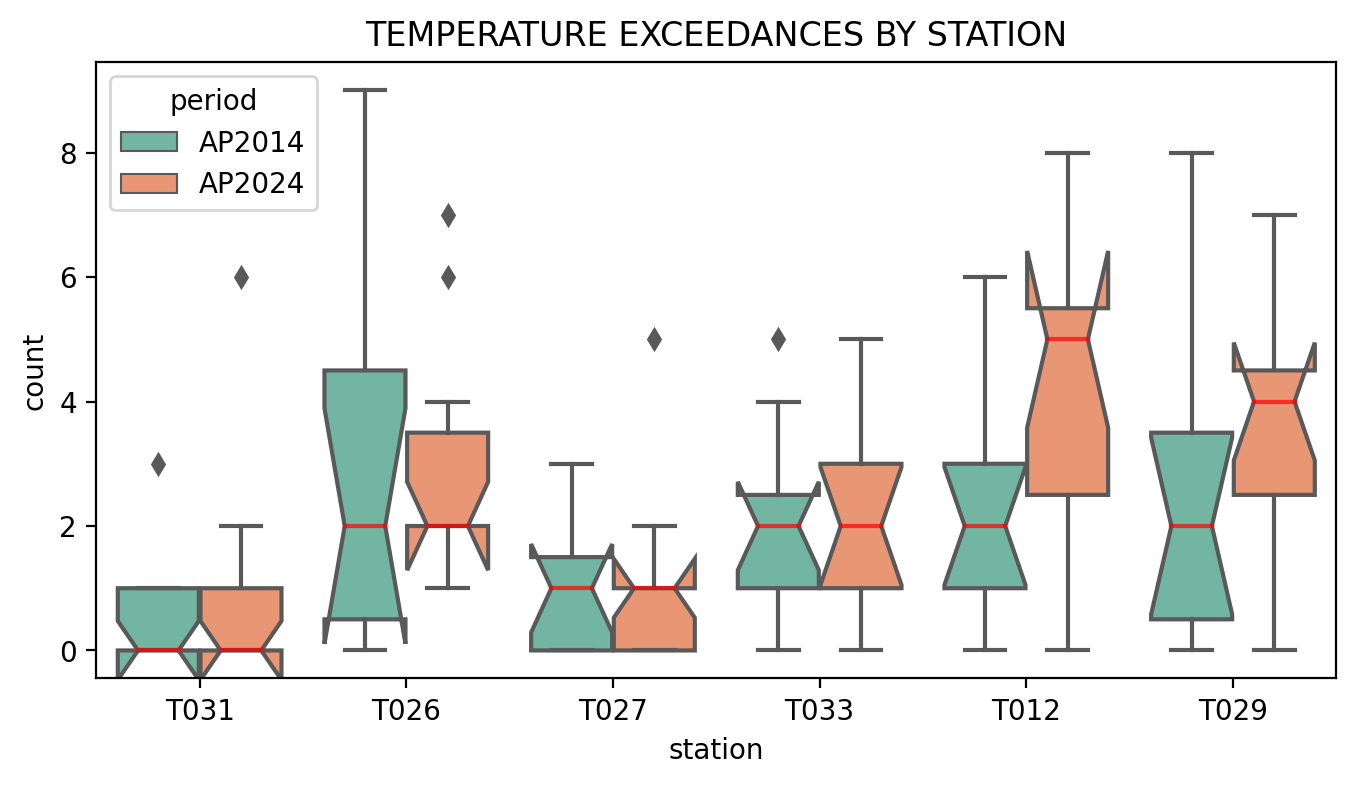

In [89]:

plt.figure(figsize=(8,4))
ax = plt.gca()
sns.boxplot(x='variable',y='value',hue='period',data=ex_cnt_1h.melt(id_vars='period',value_vars=stations), \
            notch=True, palette='Set2', order=sorted_stns,medianprops=dict(color="red", alpha=0.7))
ax.set(xlabel='station',ylabel='count',title='TEMPERATURE EXCEEDANCES BY STATION')
plt.savefig(os.path.join(fig_path,'boxplot_1H_temperature_exceedances'),bbox_inches = 'tight')

<Axes: xlabel='variable', ylabel='value'>

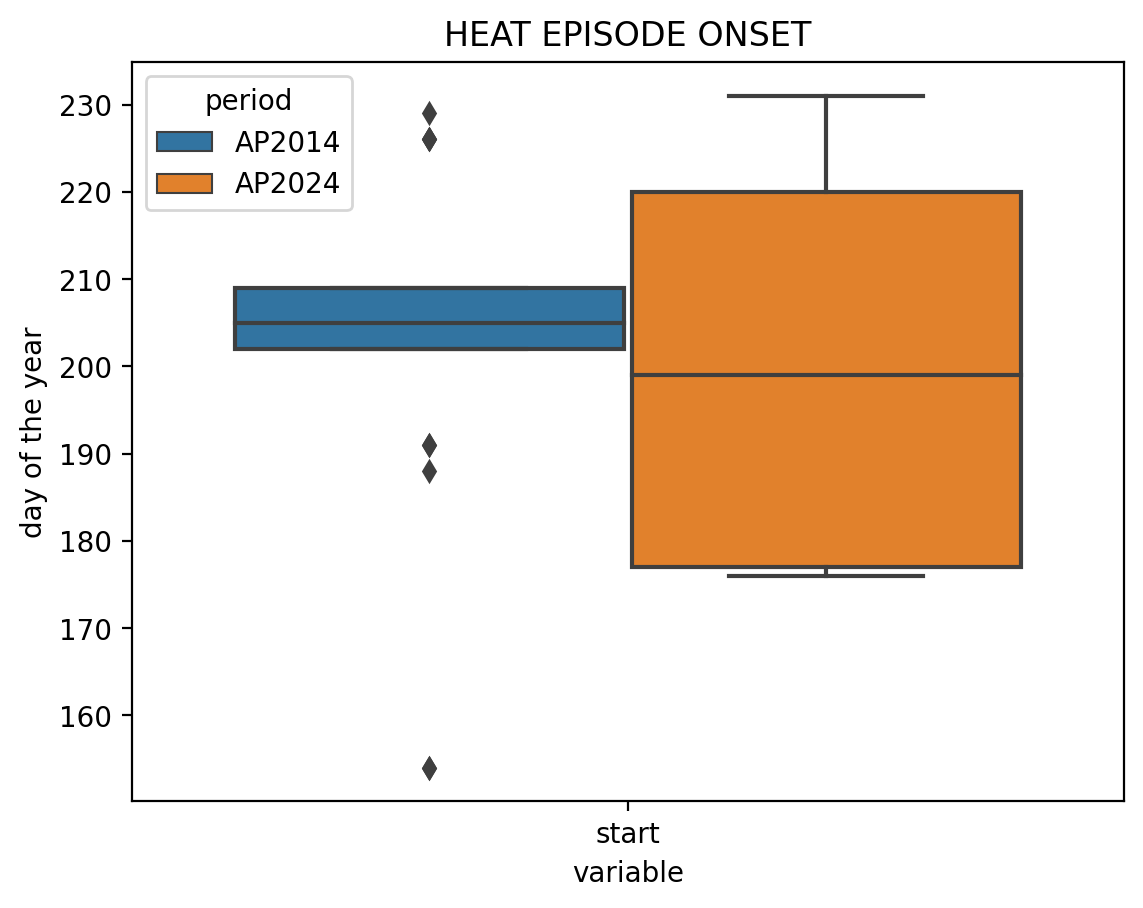

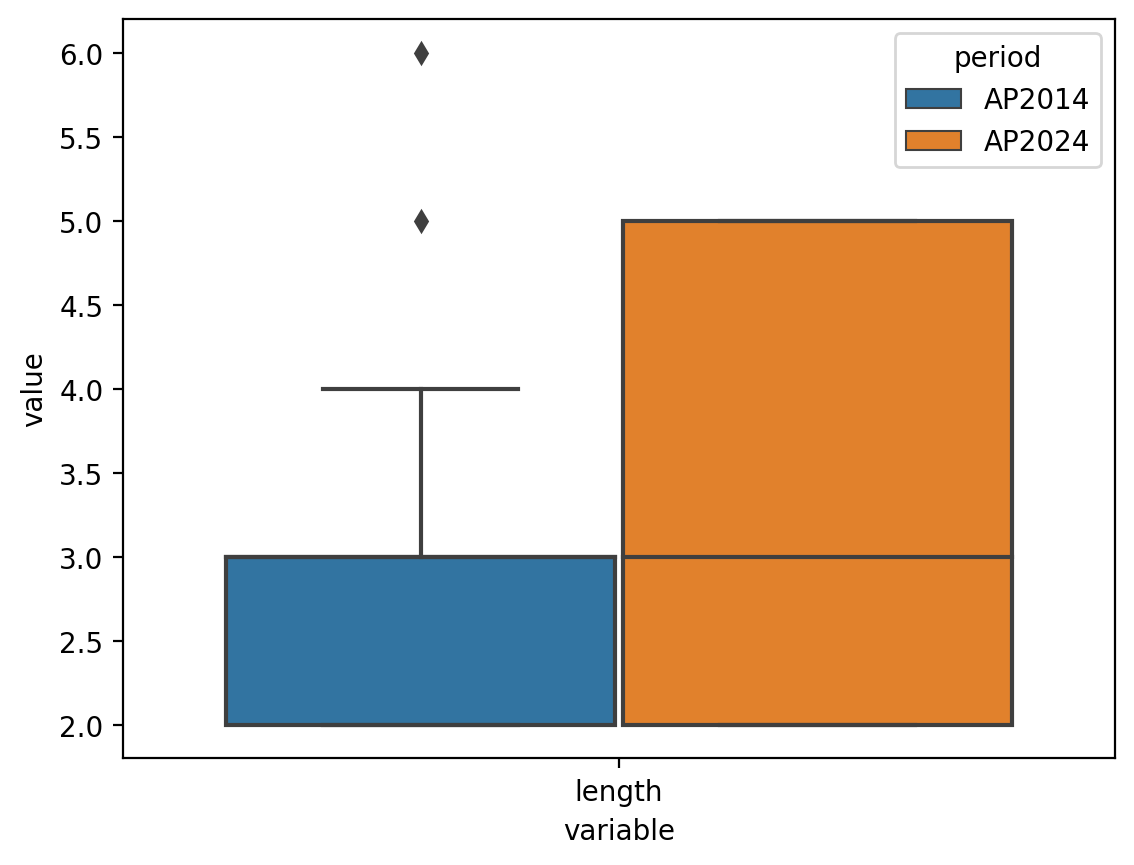

In [94]:
heat_events.groupby('year')

In [96]:
heat_events.groupby('year').count()

station  start  length  AP  period
year                                    
2004        4      4       4   4       4
2006        4      4       4   4       4
2007        2      2       2   2       2
2009        6      6       6   6       6
2010        4      4       4   4       4
2012        1      1       1   1       1
2013        1      1       1   1       1
2015        1      1       1   1       1
2016        1      1       1   1       1
2017        1      1       1   1       1
2018        3      3       3   3       3
2021        6      6       6   6       6
2022        2      2       2   2       2
2023        2      2       2   2       2

In [88]:
heat_events['period'] = np.nan
heat_events.loc[heat_events.year<2013, ['period']] = 'AP2014'
heat_events.loc[heat_events.year>=2013, ['period']] = 'AP2024'
heat_events

plt.figure()
sns.boxplot(x='variable',y='value',hue='period', data=heat_events.melt(id_vars='period',value_vars='start'))
plt.gca().set(title='HEAT EPISODE ONSET', ylabel='day of the year')
plt.figure()
sns.boxplot(x='variable',y='value',hue='period', data=heat_events.melt(id_vars='period',value_vars='length'))

year station start length      AP  period
0   2004    T012   205      2  AP2014  AP2014
1   2006    T012   202      2  AP2014  AP2014
2   2007    T012   191      2  AP2014  AP2014
3   2009    T012   154      5  AP2014  AP2014
4   2010    T012   188      3  AP2014  AP2014
5   2021    T012   176      5  AP2024  AP2024
6   2022    T012   177      4  AP2024  AP2024
7   2023    T012   225      4  AP2024  AP2024
8   2004    T026   205      3  AP2014  AP2014
9   2006    T026   202      2  AP2014  AP2014
10  2009    T026   154      6  AP2014  AP2014
11  2010    T026   226      3  AP2014  AP2014
12  2012    T026   229      2  AP2014  AP2014
13  2013    T026   181      2  AP2024  AP2024
14  2018    T026   220      3  AP2024  AP2024
15  2021    T026   177      5  AP2024  AP2024
16  2022    T026   207      5  AP2024  AP2024
17  2009    T027   209      3  AP2014  AP2014
18  2021    T027   177      3  AP2024  AP2024
19  2004    T029   204      3  AP2014  AP2014
20  2006    T029   202      3  AP2014  AP2014
21  2007    T029   191      2  AP2014  AP2014
22  2009    T029   208      4  AP2014  AP2014
23  2010    T029   226      2  AP2014  AP2014
24  2015    T029   199      2  AP2024  AP2024
25  2016    T029   231      2  AP2024  AP2024
26  2017    T029   213      3  AP2024  AP2024
27  2018    T029   220      2  AP2024  AP2024
28  2021    T029   176      5  AP2024  AP2024
29  2023    T029   225      4  AP2024  AP2024
30  2009    T031   209      3  AP2014  AP2014
31  2021    T031   177      5  AP2024  AP2024
32  2004    T033   205      2  AP2014  AP2014
33  2006    T033   202      2  AP2014  AP2014
34  2009    T033   209      3  AP2014  AP2014
35  2010    T033   226      2  AP2014  AP2014
36  2018    T033   220      2  AP2024  AP2024
37  2021    T033   177      3  AP2024  AP2024

from matplotlib import pyplot as plt
import seaborn as sns
heat_events.groupby('station').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
heat_events.groupby('length').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
heat_events.groupby('AP').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
heat_events.groupby('period').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = heat_events.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('station')):
  _plot_series(series, series_name, i)
  fig.legend(title='station', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = heat_events.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('length')):
  _plot_series(series, series_name, i)
  fig.legend(title='length', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = heat_events.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('AP')):
  _plot_series(series, series_name, i)
  fig.legend(title='AP', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = heat_events.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('period')):
  _plot_series(series, series_name, i)
  fig.legend(title='period', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['length'].value_counts()
    for x_label, grp in heat_events.groupby('station')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('station')
_ = plt.ylabel('length')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['AP'].value_counts()
    for x_label, grp in heat_events.groupby('length')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('length')
_ = plt.ylabel('AP')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['period'].value_counts()
    for x_label, grp in heat_events.groupby('AP')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('AP')
_ = plt.ylabel('period')

No ozone data for given period: 2009-06-03 00:00:00 at T026


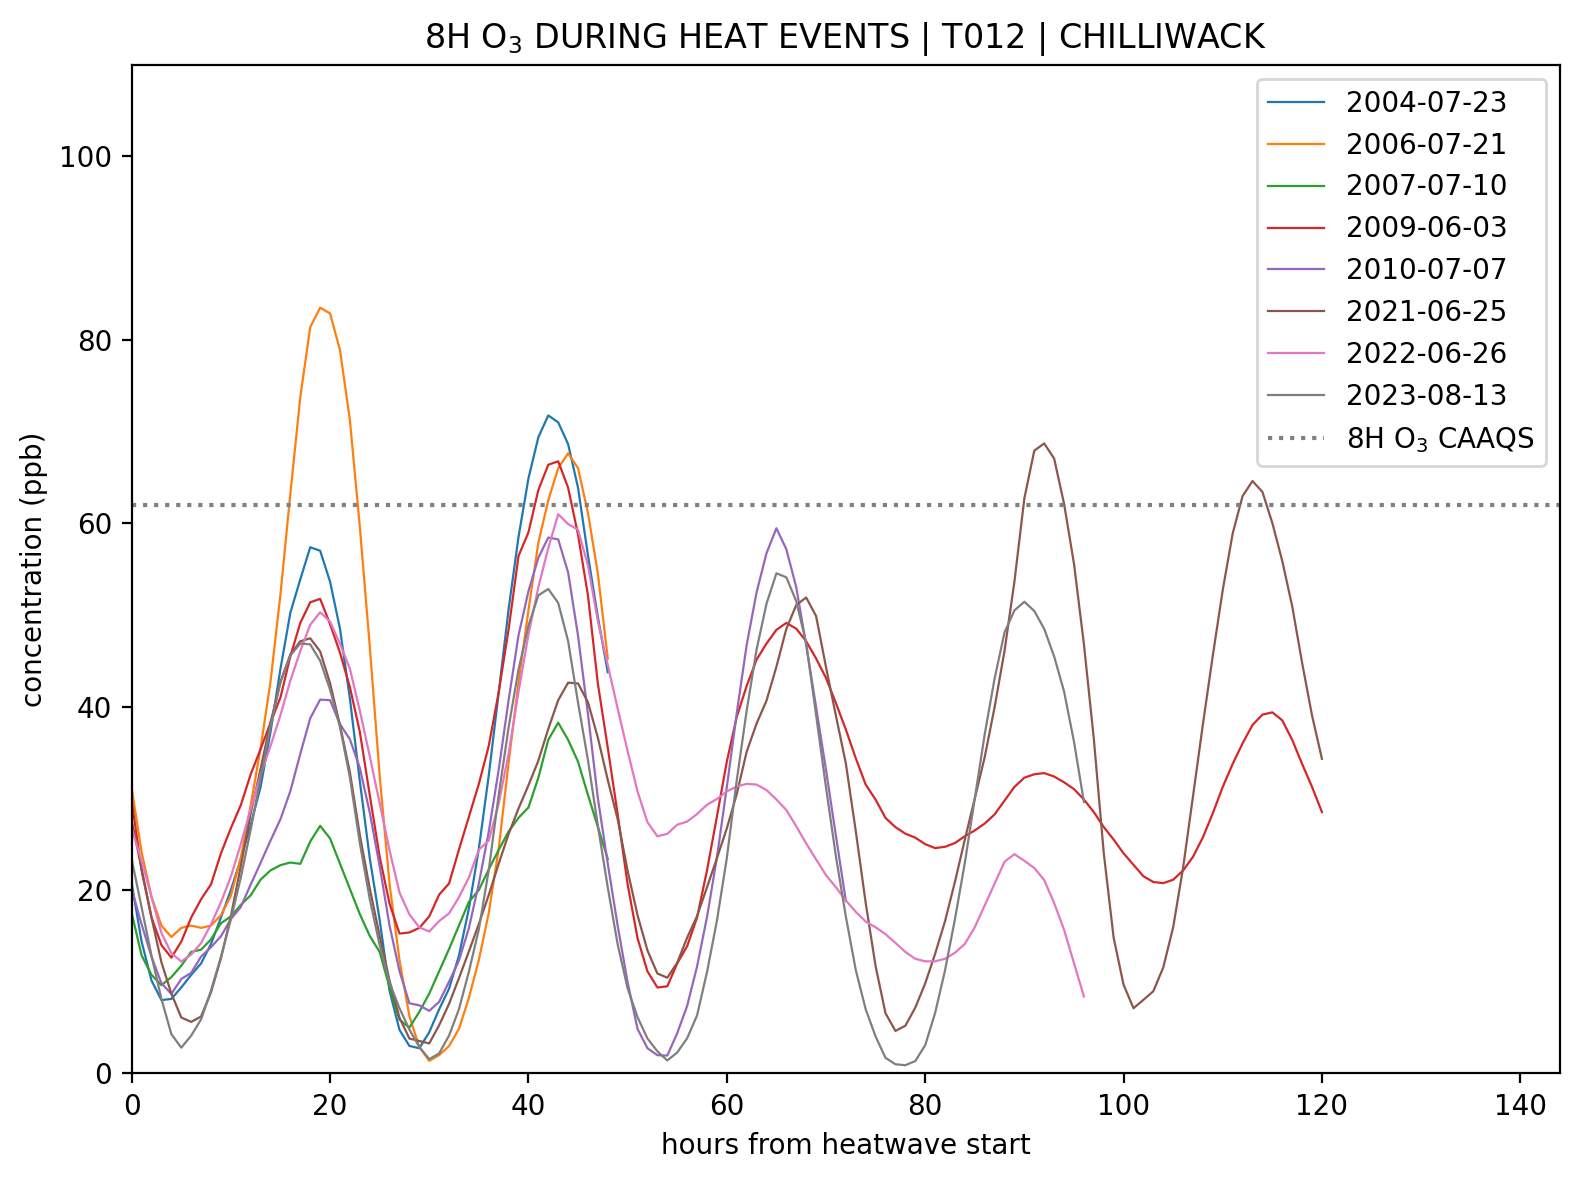

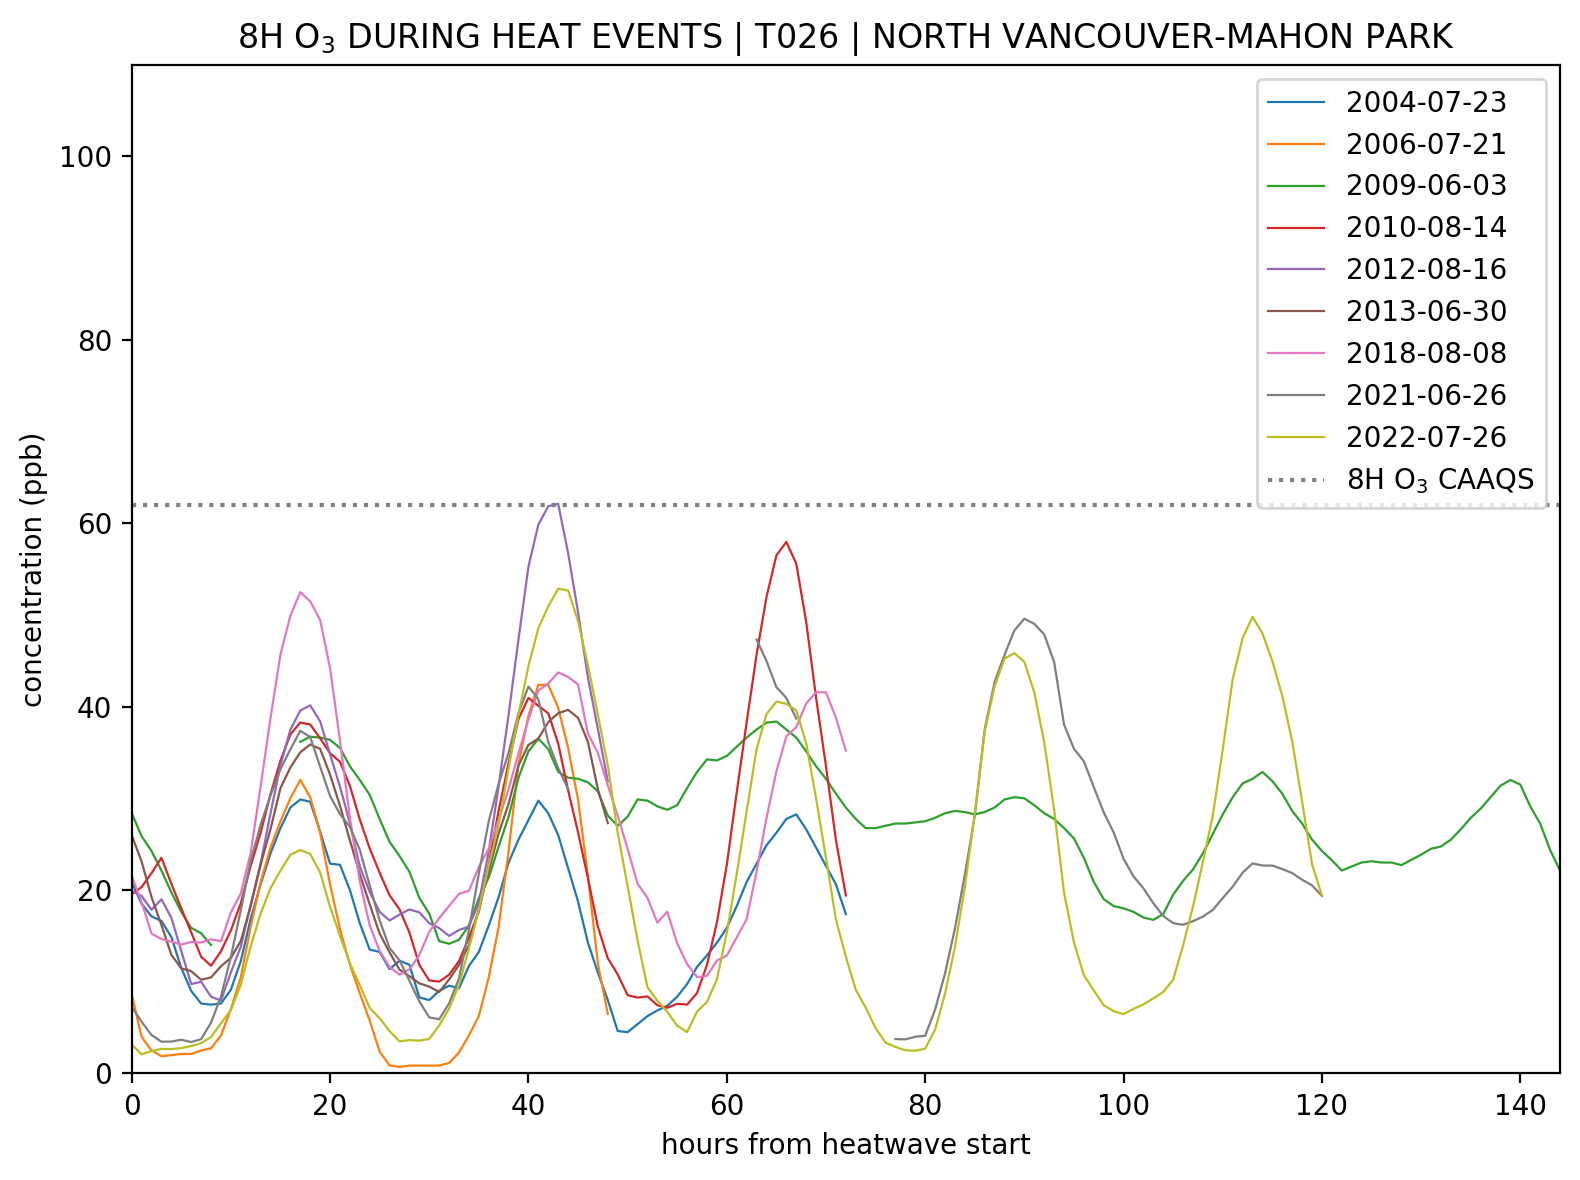

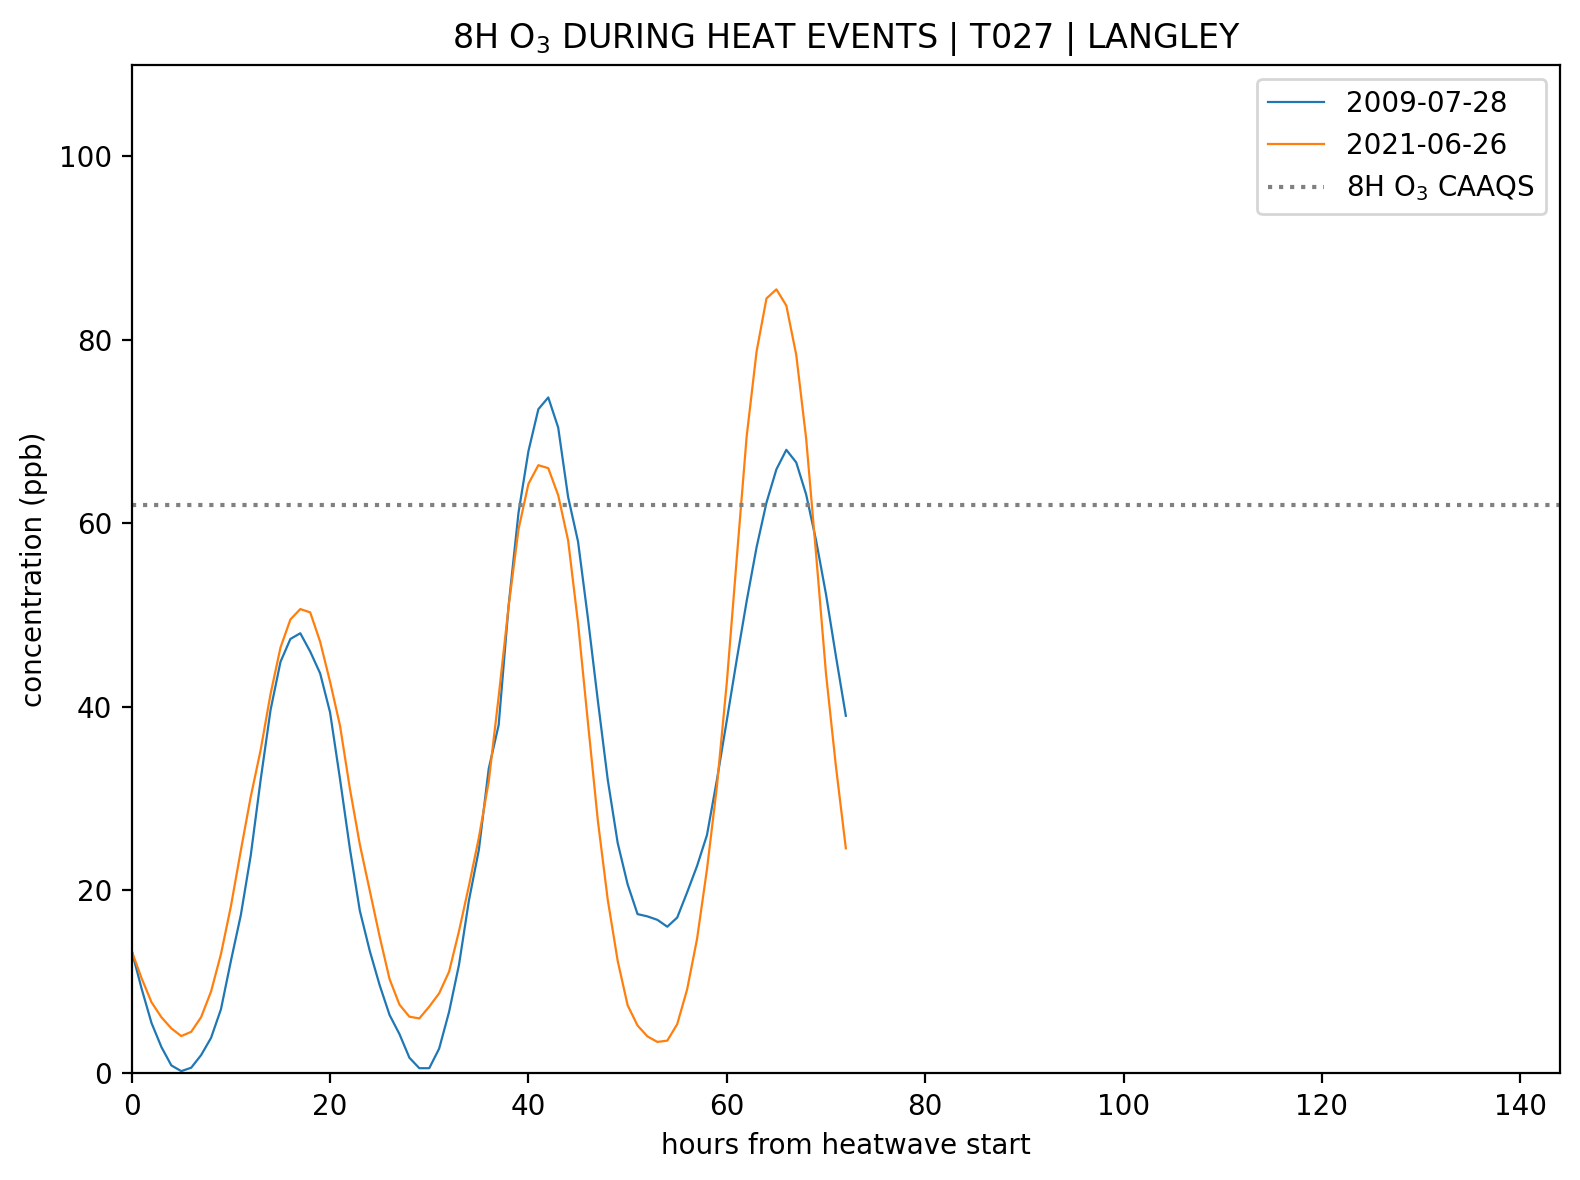

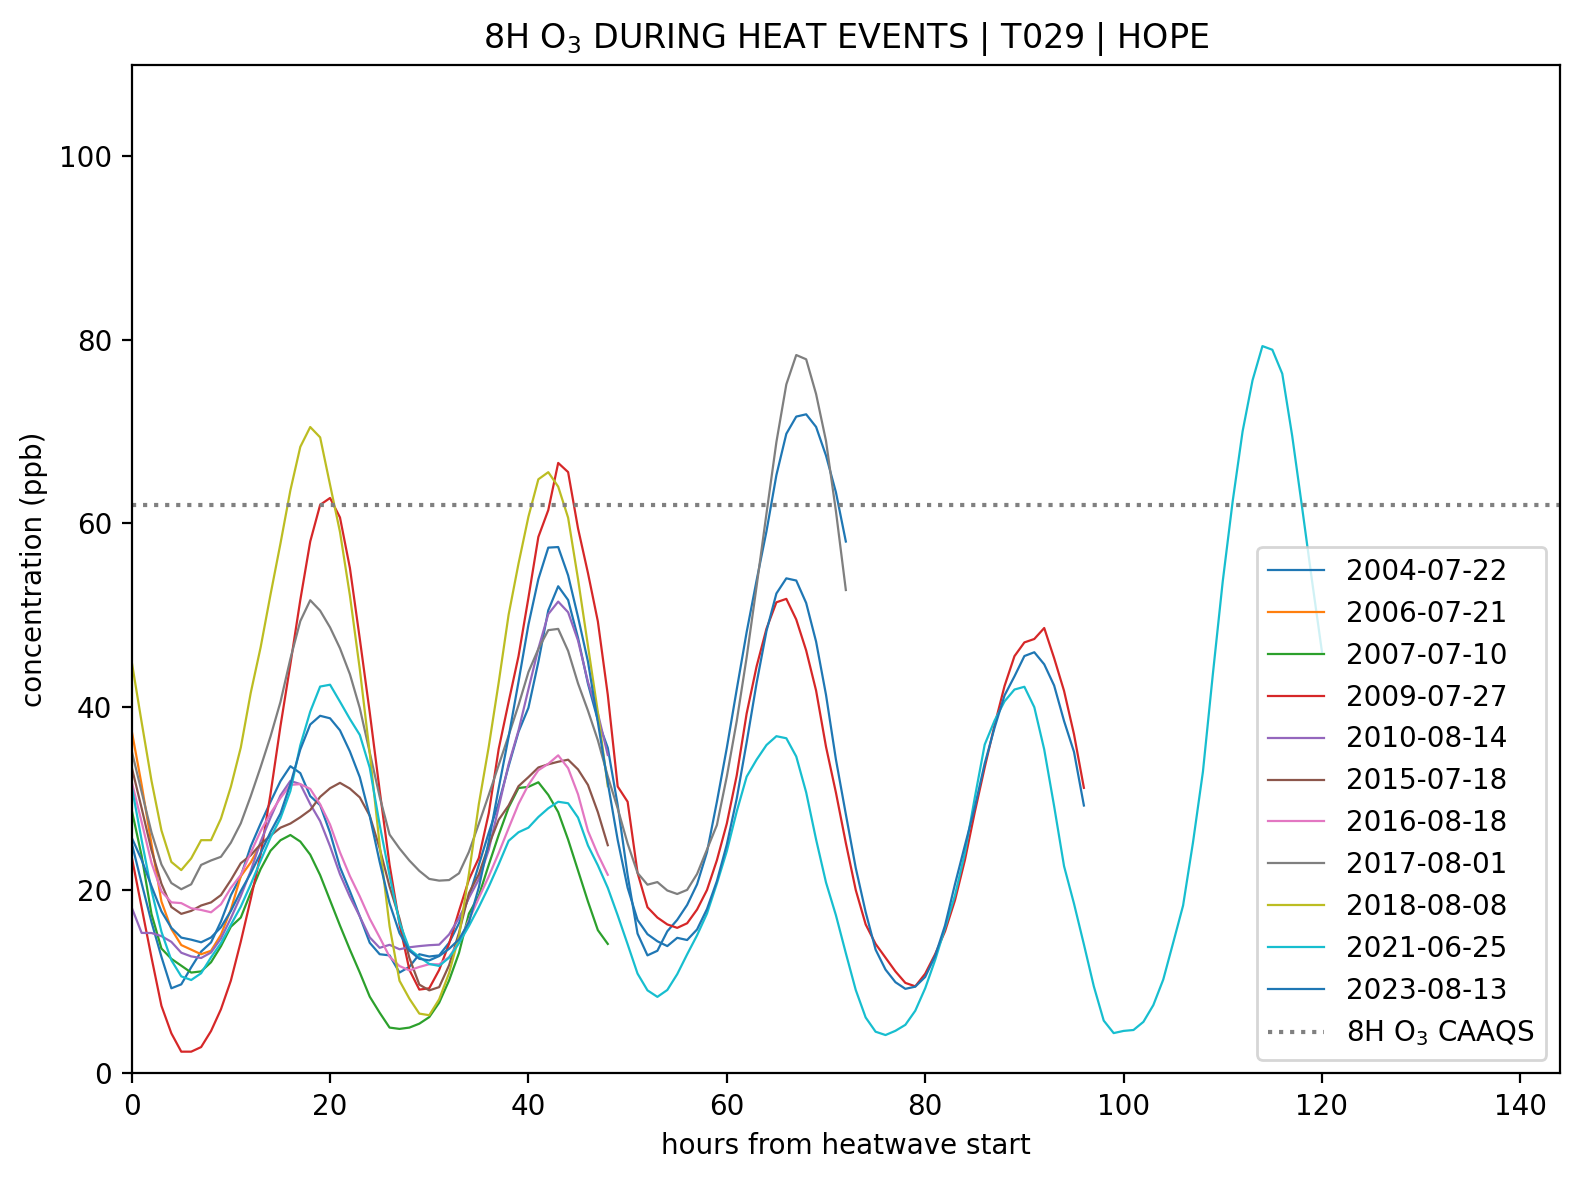

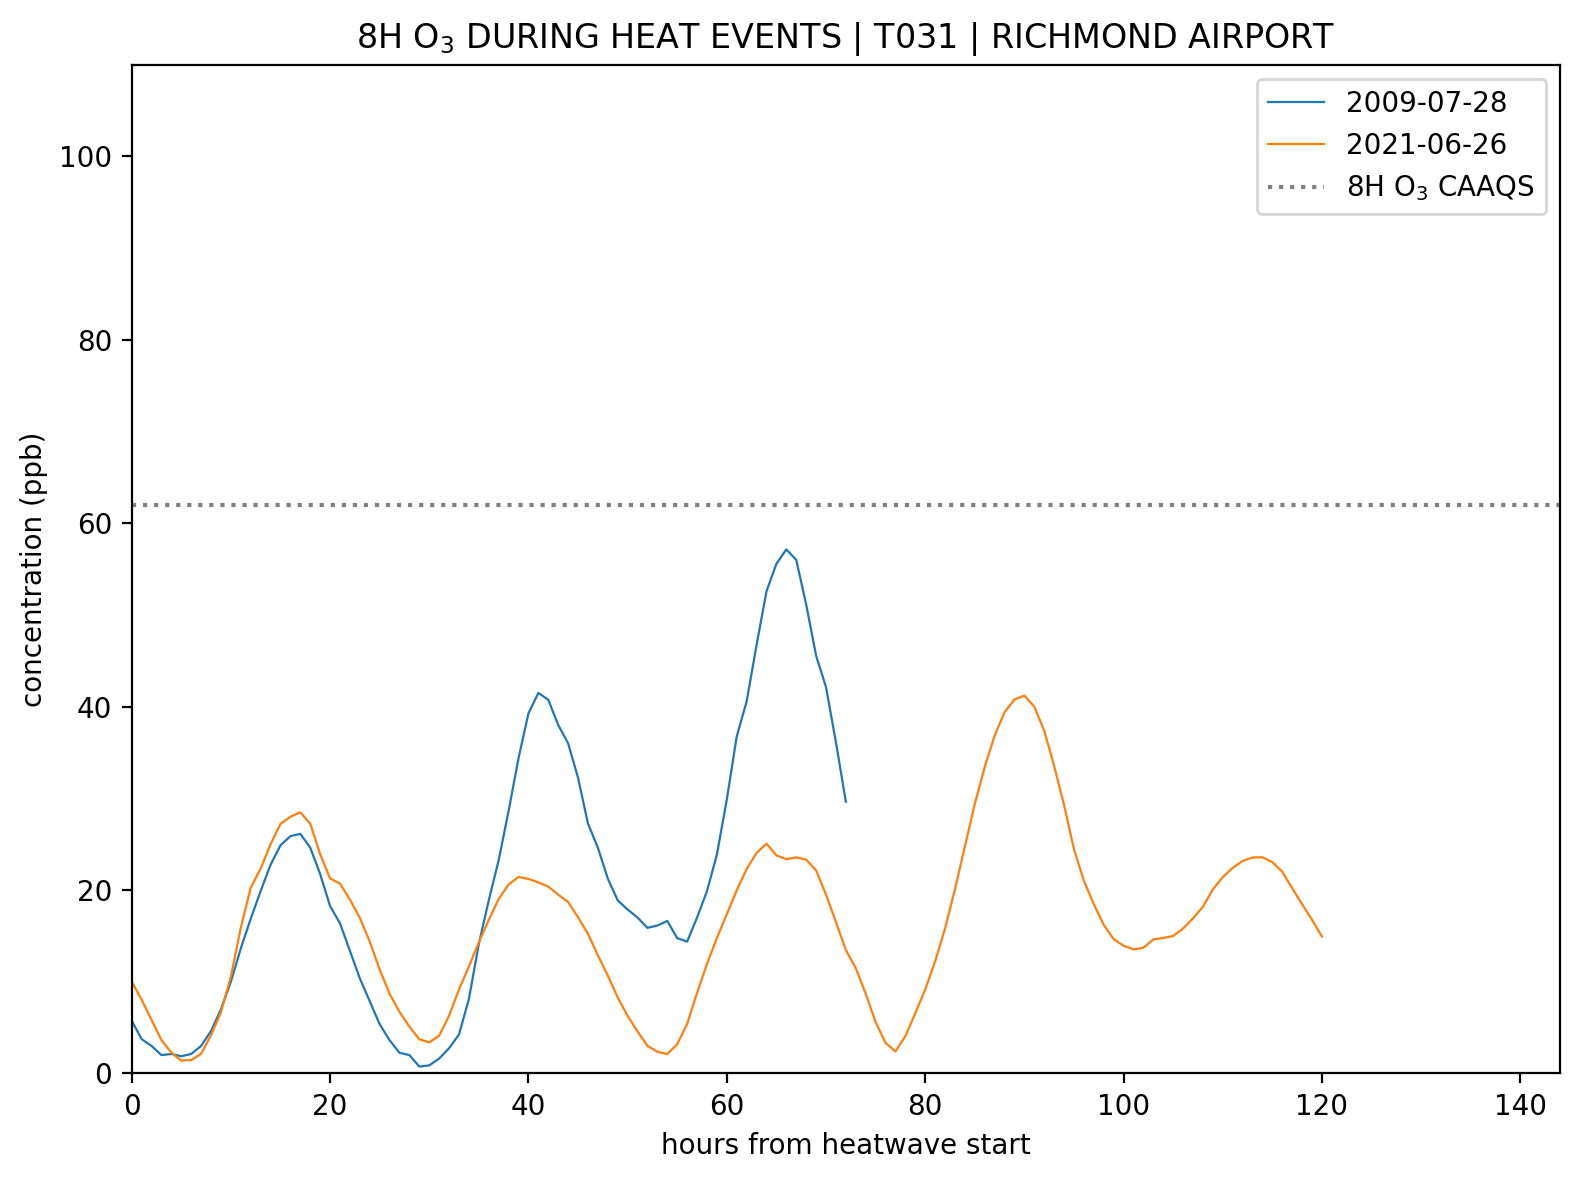

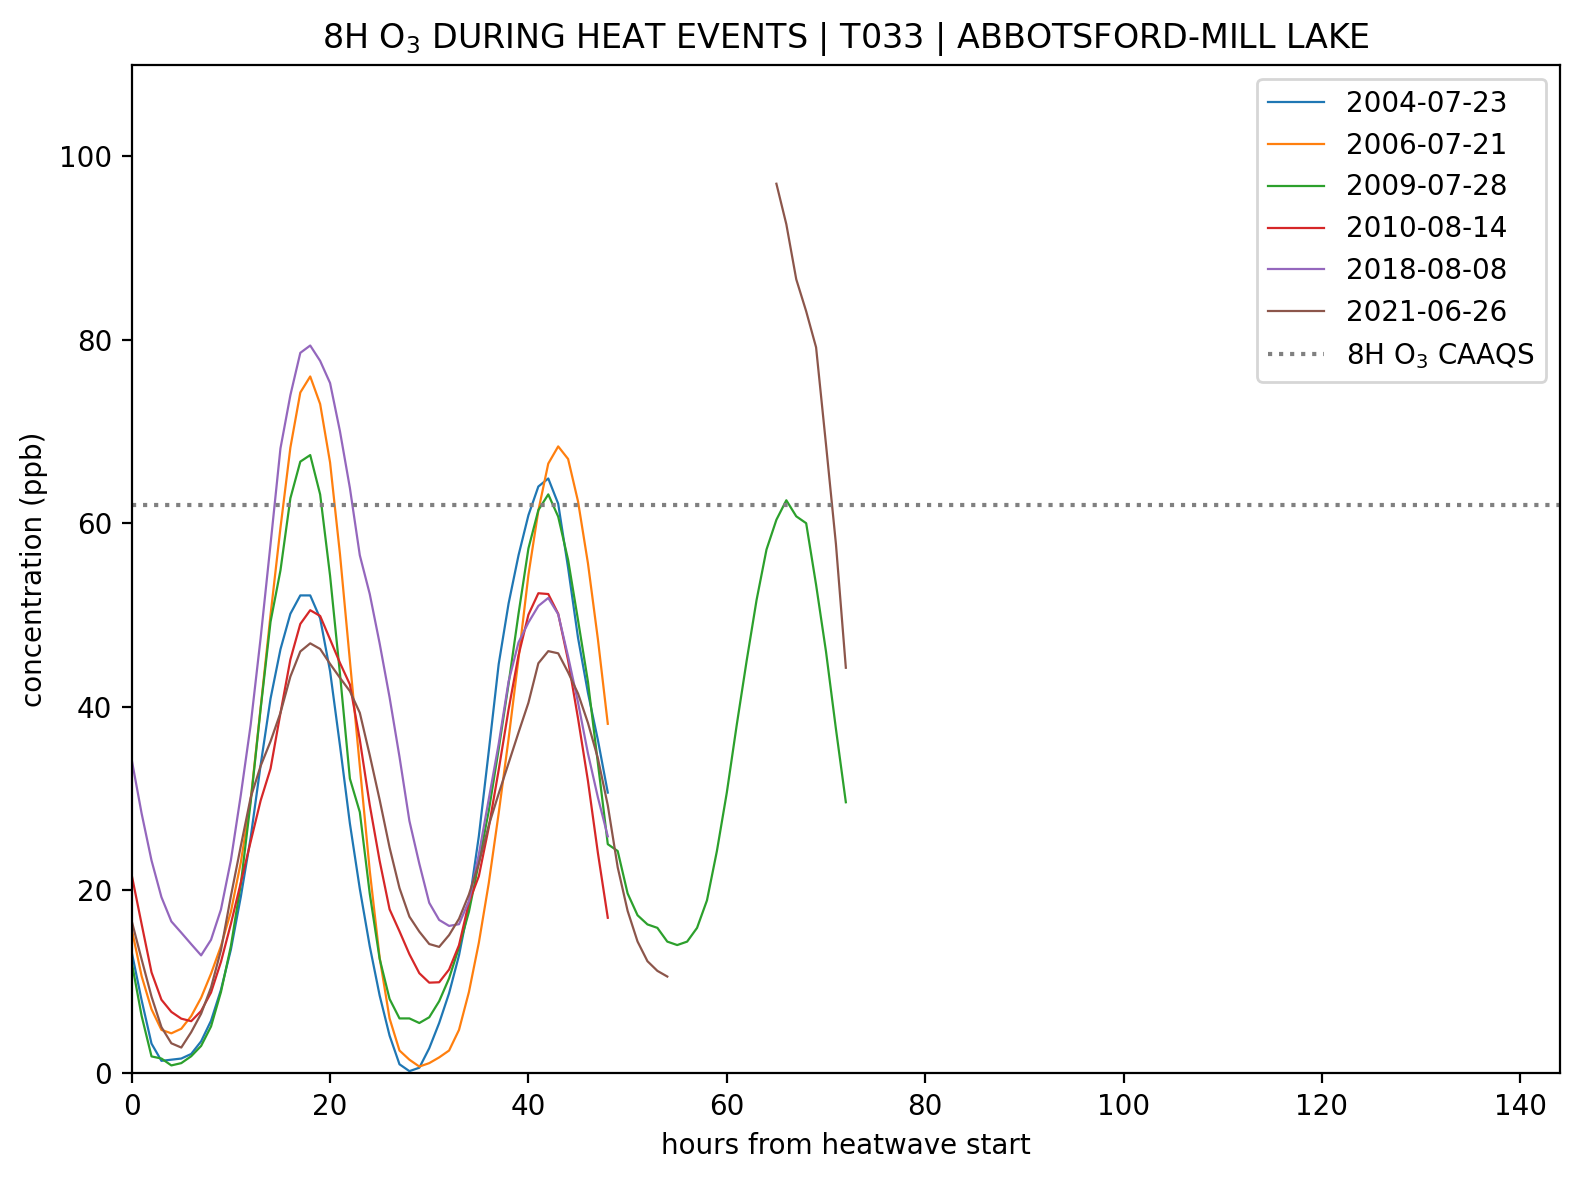

In [25]:

#-------plot what happens to ozone during heat events---------
ozone_1h = pd.read_pickle(ozone_1h_path)
ozone_8h = pd.read_pickle(ozone_8h_path)

#storage array for all ozone
store_heat_ozone = np.empty((heat_events.count()[0],heat_events.length.max()*24)) * np.nan

# #-------1h ozone-------------
# for stn in heat_events.groupby('station'):
#   plt.figure(figsize=(8,6))
#   ax=plt.gca()
#   for event in stn[1].groupby('year'):
#     heat_start = pd.to_datetime(event[1].year * 1000 + event[1].start, format='%Y%j').item()
#     heat_end = heat_start + pd.Timedelta(days=event[1].length.item())
#     try:
#       wave_ozone = ozone_1h.loc[heat_start:heat_end,stn[0]]
#       wave_ozone.index = [int(idx.total_seconds() / 3600) for idx in (wave_ozone.index - wave_ozone.index[0])]
#       wave_ozone.plot(label=heat_start.strftime('%Y-%m-%d'))
#     except:
#       print(f'No ozone data for given period: {heat_start} at {stn[0]}')
#   plt.axhline(y=82,c='gray',linestyle=':',label=f'1H O$_3$ CAAQS')
#   plt.legend()
#   ax.set(title=f'1H O$_3$ DURING HEAT EVENTS | {stn[0]} | {meta.loc[stn[0],"StationName"]}', xlabel='hours from heatwave start',ylabel='concentration (ppb)',\
#          xlim=[0,heat_events.length.max()*24], ylim=[0,130])

#-------8h ozone-------------
cnt = 0
for stn in heat_events.groupby('station'):
  plt.figure(figsize=(8,6))
  ax=plt.gca()
  for event in stn[1].groupby('year'):
    heat_start = pd.to_datetime(event[1].year * 1000 + event[1].start, format='%Y%j').item()
    heat_end = heat_start + pd.Timedelta(days=event[1].length.item())
    try:
      wave_ozone = ozone_8h.loc[heat_start:heat_end,stn[0]]
      wave_ozone.index = [int(idx.total_seconds() / 3600) for idx in (wave_ozone.index - wave_ozone.index[0])]
      wave_ozone.plot(label=heat_start.strftime('%Y-%m-%d'),linewidth=0.8)
      store_heat_ozone[cnt,:len(wave_ozone)] = wave_ozone
      cnt = cnt + 1
    except:
      print(f'No ozone data for given period: {heat_start} at {stn[0]}')
      cnt = cnt + 1
  plt.axhline(y=62,c='gray',linestyle=':',label=f'8H O$_3$ CAAQS')
  plt.legend()
  ax.set(title=f'8H O$_3$ DURING HEAT EVENTS | {stn[0]} | {meta.loc[stn[0],"StationName"]}', xlabel='hours from heatwave start',ylabel='concentration (ppb)',\
         xlim=[0,heat_events.length.max()*24], ylim=[0,110])
  plt.tight_layout()
  plt.savefig(os.path.join(fig_path, f'{stn[0]}_heat_episodes.pdf'),bbox_inches = 'tight')




<ipython-input-58-fc35de55ecc0>:1: RuntimeWarning: Mean of empty slice
  norm_mean_ozone = np.nanmean(norm_heat_ozone,0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<ipython-input-63-5a6dfee5cc51>:6: RuntimeWarning: Mean of empty slice
  norm_mean_ozone = np.nanmean(norm_heat_ozone,0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


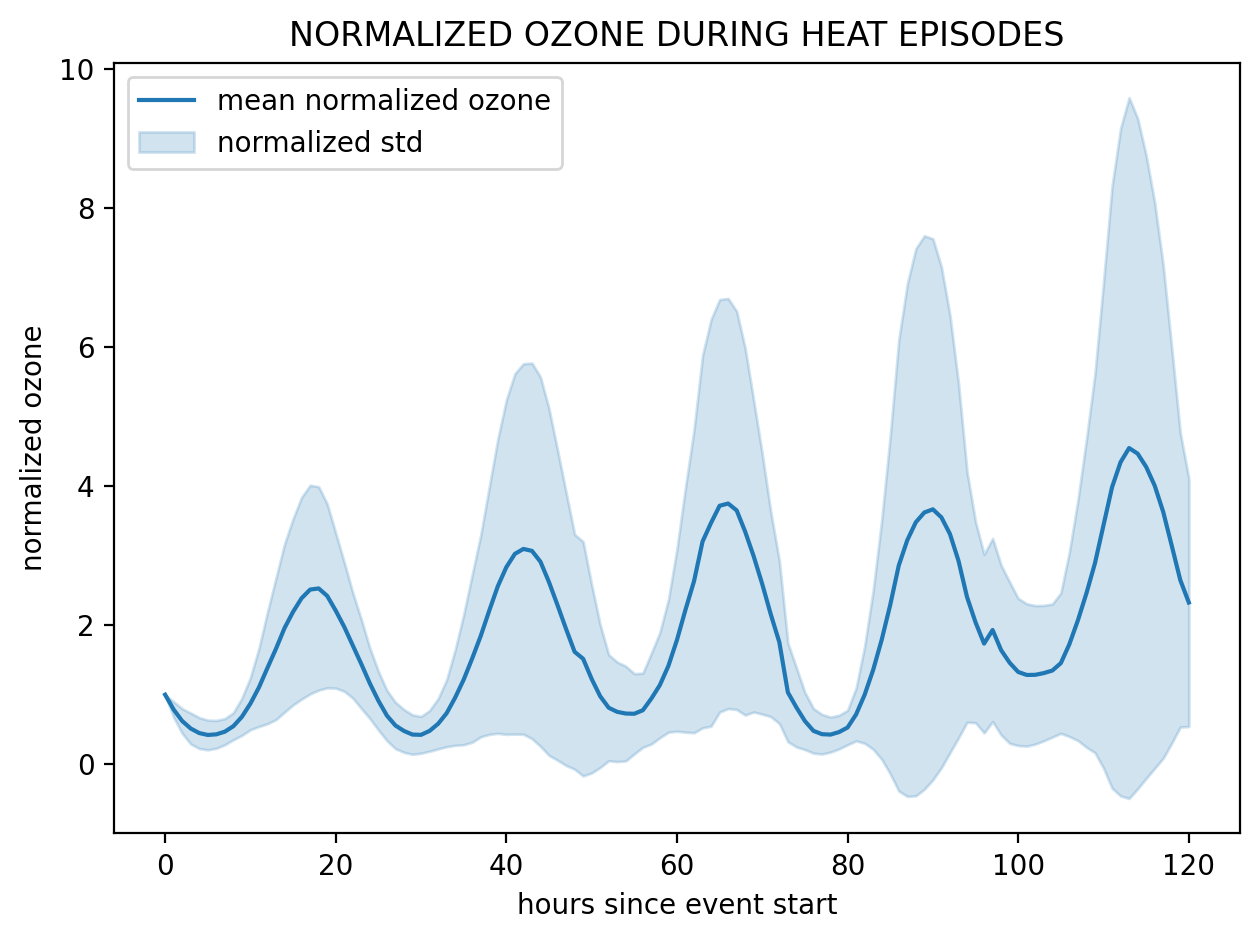

In [63]:


norm_heat_ozone = []
for row in store_heat_ozone:
  # print(row)
  norm_heat_ozone.append(row/row[0])

norm_mean_ozone = np.nanmean(norm_heat_ozone,0)
std_mean_ozone = np.nanstd(norm_heat_ozone,0)


plt.figure()
x = np.arange(len(norm_mean_ozone))
plt.plot(x, norm_mean_ozone, 'C0', label='mean normalized ozone')
plt.fill_between(x, norm_mean_ozone - std_mean_ozone, norm_mean_ozone + std_mean_ozone, color='C0', alpha=0.2, label='normalized std')
plt.legend(loc=2)
plt.gca().set(title='NORMALIZED OZONE DURING HEAT EPISODES', xlabel='hours since event start', ylabel = 'normalized ozone')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, f'Normlized_heat_ozone.pdf'),bbox_inches = 'tight')

In [38]:
mean_heat_ozone = np.nanmean(norm_heat_ozone, axis=0)

<ipython-input-38-7fa35de0e1c7>:1: RuntimeWarning: Mean of empty slice
  mean_heat_ozone = np.nanmean(norm_heat_ozone, axis=0)
